In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from transformers import AutoTokenizer
from datasets import Dataset, load_dataset

from pathlib import Path

In [2]:
data_dir = Path("../data/interim/")
ckpt = "bert-base-uncased"

## Tokenize text

In [3]:
tokenizer = AutoTokenizer.from_pretrained(ckpt, use_fast=True)

### Exploring tokenizer and thoughts on improving model prediction with different tokenizers
1. Volcabulary is 305222,: larger vocab greater accuracy?
2. Is there a tokenizer that will be useful medical data
3. 

In [4]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [5]:
df = pd.read_csv(data_dir/"wndp-api-ohe.csv")
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.dropna(inplace=True)
df.head()

,patient_id,text,terms,clinically_healthy,dermatologic_disease,gastrointestinal_disease,hematologic_disease,neurologic_disease,nonspecific,nutritional_disease,ocular_disease,physical_injury,respiratory_disease,urogenital_disease
0,1960540,unknown. A9 - orphaned. Feathers / Fur / Skin:...,['Clinically healthy'],1,0,0,0,0,0,0,0,0,0,0
1,548645,HBC. HBC/NSF. Eyes / Ears / Mouth / Nares: squ...,['Physical injury'],0,0,0,0,0,0,0,0,1,0,0
2,1905573,"Dragging leg, circling. Shock, Bleeding from M...",['Physical injury'],0,0,0,0,0,0,0,0,1,0,0
3,2741655,Weak. NSF. Eyes / Ears / Mouth / Nares: Eyes s...,['Clinically healthy'],1,0,0,0,0,0,0,0,0,0,0
4,2637768,Removed / Displaced (Juvenile) - Nest / Nest s...,['Nonspecific'],0,0,0,0,0,1,0,0,0,0,0


In [6]:
df.shape

(14040, 14)

In [7]:
sample = df.text[:5]
sample[3]

'Weak. NSF. Eyes / Ears / Mouth / Nares: Eyes slightly dry and difficult to perform full fundic exam, but no obvious abnormalities'

In [8]:
tokenizer(sample[3])

{'input_ids': [101, 5410, 1012, 24978, 2546, 1012, 2159, 1013, 5551, 1013, 2677, 1013, 6583, 6072, 1024, 2159, 3621, 4318, 1998, 3697, 2000, 4685, 2440, 4636, 2594, 11360, 1010, 2021, 2053, 5793, 28828, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [9]:
tokens = tokenizer.tokenize(sample[3])
tokens

['weak',
 '.',
 'ns',
 '##f',
 '.',
 'eyes',
 '/',
 'ears',
 '/',
 'mouth',
 '/',
 'na',
 '##res',
 ':',
 'eyes',
 'slightly',
 'dry',
 'and',
 'difficult',
 'to',
 'perform',
 'full',
 'fund',
 '##ic',
 'exam',
 ',',
 'but',
 'no',
 'obvious',
 'abnormalities']

In [10]:
ids = tokenizer.convert_tokens_to_ids(tokens)
ids

[5410,
 1012,
 24978,
 2546,
 1012,
 2159,
 1013,
 5551,
 1013,
 2677,
 1013,
 6583,
 6072,
 1024,
 2159,
 3621,
 4318,
 1998,
 3697,
 2000,
 4685,
 2440,
 4636,
 2594,
 11360,
 1010,
 2021,
 2053,
 5793,
 28828]

In [11]:
tokenizer.decode(ids)

'weak. nsf. eyes / ears / mouth / nares : eyes slightly dry and difficult to perform full fundic exam, but no obvious abnormalities'

In [12]:
tokenizer.decode(tokenizer(sample[3])["input_ids"])

'[CLS] weak. nsf. eyes / ears / mouth / nares : eyes slightly dry and difficult to perform full fundic exam, but no obvious abnormalities [SEP]'

## Build the dataset

In [13]:
# Pick only the columns we need for the model
df = df[list(set(df.columns).difference({"patient_id", "terms"}))]
df.head()

,text,neurologic_disease,hematologic_disease,nonspecific,respiratory_disease,dermatologic_disease,urogenital_disease,ocular_disease,physical_injury,nutritional_disease,gastrointestinal_disease,clinically_healthy
0,unknown. A9 - orphaned. Feathers / Fur / Skin:...,0,0,0,0,0,0,0,0,0,0,1
1,HBC. HBC/NSF. Eyes / Ears / Mouth / Nares: squ...,0,0,0,0,0,0,0,1,0,0,0
2,"Dragging leg, circling. Shock, Bleeding from M...",0,0,0,0,0,0,0,1,0,0,0
3,Weak. NSF. Eyes / Ears / Mouth / Nares: Eyes s...,0,0,0,0,0,0,0,0,0,0,1
4,Removed / Displaced (Juvenile) - Nest / Nest s...,0,0,1,0,0,0,0,0,0,0,0


In [14]:
# Split dataset into train, val & test set
_ds = (Dataset
          .from_pandas(df)
          .train_test_split(test_size=0.15, 
                            shuffle=True)
     )
ds = _ds["train"].train_test_split(test_size=0.2)
ds["val"] = ds.pop("test")
ds["test"] = _ds["test"]

In [15]:
ds = ds.remove_columns(column_names=["__index_level_0__"])

In [16]:
labels = sorted(ds["train"].column_names)
labels.remove("text")
labels

['clinically_healthy',
 'dermatologic_disease',
 'gastrointestinal_disease',
 'hematologic_disease',
 'neurologic_disease',
 'nonspecific',
 'nutritional_disease',
 'ocular_disease',
 'physical_injury',
 'respiratory_disease',
 'urogenital_disease']

In [17]:
# Add labels to the dataset as float (pytorch excepts float tensors)
ds = ds.map(lambda row: {"labels": [float(row[l]) for l in labels]})

Map:   0%|          | 0/9547 [00:00<?, ? examples/s]

Map:   0%|          | 0/2387 [00:00<?, ? examples/s]

Map:   0%|          | 0/2106 [00:00<?, ? examples/s]

In [18]:
ds["train"][0]

{'text': 'Collision - Car (2 separate calls in the afternoon about an owl on the side of the road just before the weigh station on the ID side of the pass (though still in WY).  BC and CA went and picked up the bird at about 3:15p.  Found readily.). Trauma - Head; Eye Trauma - Uveitis (L). Eyes / Ears / Mouth / Nares: Left pupil is enlarged and left ear has fresh blood coming out of it.  Blood in the mouth that appears to be coming from the sinus area. Neurologic: head trauma. Left pupil is enlarged and left ear has fresh blood coming out of it.  Blood in the mouth that appears to be coming from the sinus area.  No broken bones palpated, but bird is extremely lethargic so we will wait and x-ray tomorrow. Additional notes about meds given on daily log',
 'neurologic_disease': 1,
 'hematologic_disease': 0,
 'nonspecific': 0,
 'respiratory_disease': 0,
 'dermatologic_disease': 0,
 'urogenital_disease': 0,
 'ocular_disease': 1,
 'physical_injury': 1,
 'nutritional_disease': 0,
 'gastrointe

In [19]:
ds["train"][226] 

{'text': 'Unknown. Eyes / Ears / Mouth / Nares: Possible vision problems, but light responsive  Neurologic: Mild neurological symptoms, unbalanced',
 'neurologic_disease': 1,
 'hematologic_disease': 0,
 'nonspecific': 0,
 'respiratory_disease': 0,
 'dermatologic_disease': 0,
 'urogenital_disease': 0,
 'ocular_disease': 0,
 'physical_injury': 0,
 'nutritional_disease': 0,
 'gastrointestinal_disease': 0,
 'clinically_healthy': 0,
 'labels': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

Let us look at how long is each of the text description

In [20]:
text_stats = np.array([len(row.split()) if row else 0 for row in ds["train"]["text"]])

<Axes: ylabel='Count'>

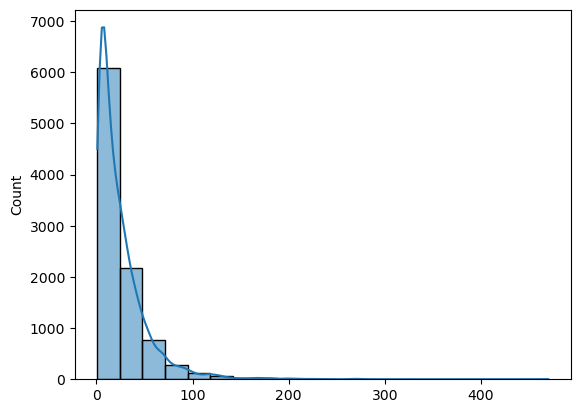

In [21]:
sns.histplot(text_stats, bins=20, kde=True)

In [22]:
(text_stats < 3).sum()/len(text_stats)

0.05666701581648685

1% of the data have words more than 128 words

In [23]:
(text_stats > 128).sum()/len(text_stats)

0.010055514821409867

In [24]:
(text_stats > 200).sum()/len(text_stats)

0.0023043888132397612

In [25]:
for row in ds["train"]["text"]:
    if len(row.split()) < 3:
        print(row)

Sick. bronhopneumonia
Trichomonoza. Trichomonosis
Grounded. Healthy
Orphaned. DOA
Trichomonosis. Trichomonosis
NSF. NSF
Orphaned
Collision. NSF
Orphaned. Orphaned
Chronic apathy
Appeared sick
Unsafe Area
NSF
Displaced. Displaced
NSF. NSF
Undetermined. Undetermined
Orphan. Orphan
unknown
orphan. orphan
orphaned
emaciated. emaciated
unknown. Moribund
Injury. injury
Unknown. NSF
Weak
Hit window
Orphaned. Orphaned
Orphaned. Orphaned
orphan. orphan
orphaned
beached
sick
Weak
Unknown. Kidnapped
Cat contact
Unknown. DOA
Healthy
Fleas
Beached
sick
orphaned
Orphan. Orphan
Unknown. NSF
Weak. Thin
Orphan. Healthy
Orphaned
Displacement. NSF
Trauma. Healthy
Orphan
Injury
Orphaned
Orphan. Healthy
cat caught
orphaned. Orphaned
lethargic
beached
Beached. Emaciated
ill
Beached. emaciated
Orphaned. Nsf
Orphaned. Healthy
Orphan. Hipocalcemie
Unknown. Mites
Orphaned. Healthy
Orphaned
NSF. NSF
Hit window
Beached. NSF
orphaned
Orphaned. orphan
beached
Orphan
hit window
Orphaned. orphan
Baby. Baby
unknown. D

In [26]:
for row in ds["train"]["text"]:
    if len(row.split()) > 200:
        print(len(row.split()), row)
        print("-" * 20)

470 Undetermined. Luxation - Elbow Joint (L). Eyes / Ears / Mouth / Nares: Initial exam showed eyes, ears, nose, and mouth are clear, but mouth seems mildly tacky. Body: Keel is pretty thin (1.5 out of 5). Wings / Arms: Luxated left elbow. Cannot be in fig-eight without popping back out. Initial exam showed eyes, ears, nose, and mouth are clear, but mouth seems mildly tacky.  Keel is pretty thin (1.5 out of 5).  Luxated left elbow. Cannot be in fig-eight without popping back out. Live checked at 9:15a - very depressed and lethargic. Leaning again the door in the ICU and didn't acknowledge when I opened the door. Immediately got O2 chamber ready for him and texted Heather and Meghan for how they'd like me to handle it. MW felt maybe he's going septic so I administered 0.3cc fresh Ampicillin and 0.13cc Baytril. Did not administer Torb or Metacam per Heather's suggestion. Gave 12cc LRS (so passive I could cradle him in one arm and push in the fluids with the other hand. Dark mouse and hai

In [27]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [37]:
#tok_ds = ds.map(tokenizer, batched=True, num_proc=16, remove_columns=labels + ["text"])

In [28]:
from huggingface_hub import login
login(token=None)


In [32]:
%%time
def tok_fn(row):
  from transformers import AutoTokenizer
  ckpt = "bert-base-uncased"  
  tokenizer = AutoTokenizer.from_pretrained(ckpt)
  return tokenizer(row["text"], 
                  truncation=True, 
                    padding="max_length", 
                    max_length=128)


#def tok_fn(row):
#    return tokenizer(row["text"], 
#                     truncation=True, 
#                     padding="max_length", 
#                     max_length=128)

tok_ds = ds.map(tok_fn, batched=True, num_proc=16, remove_columns=labels + ["text"])

Map (num_proc=16):   0%|          | 0/9547 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/2387 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/2106 [00:00<?, ? examples/s]

CPU times: total: 2.41 s
Wall time: 1min 13s


In [33]:
tok_ds

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9547
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2387
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2106
    })
})

In [34]:
tok_ds["train"][0]

{'labels': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 'input_ids': [101,
  12365,
  1011,
  2482,
  1006,
  1016,
  3584,
  4455,
  1999,
  1996,
  5027,
  2055,
  2019,
  13547,
  2006,
  1996,
  2217,
  1997,
  1996,
  2346,
  2074,
  2077,
  1996,
  17042,
  2276,
  2006,
  1996,
  8909,
  2217,
  1997,
  1996,
  3413,
  1006,
  2295,
  2145,
  1999,
  1059,
  2100,
  1007,
  1012,
  4647,
  1998,
  6187,
  2253,
  1998,
  3856,
  2039,
  1996,
  4743,
  2012,
  2055,
  1017,
  1024,
  2321,
  2361,
  1012,
  2179,
  12192,
  1012,
  1007,
  1012,
  12603,
  1011,
  2132,
  1025,
  3239,
  12603,
  1011,
  23068,
  20175,
  2483,
  1006,
  1048,
  1007,
  1012,
  2159,
  1013,
  5551,
  1013,
  2677,
  1013,
  6583,
  6072,
  1024,
  2187,
  11136,
  2003,
  11792,
  1998,
  2187,
  4540,
  2038,
  4840,
  2668,
  2746,
  2041,
  1997,
  2009,
  1012,
  2668,
  1999,
  1996,
  2677,
  2008,
  3544,
  2000,
  2022,
  2746,
  2013,
  1996,
  8254,
  2271,
  2181,
  1012

In [35]:
# Save the processed data in a parquet file
for split,split_ds in tok_ds.items():
    split_ds.to_parquet(f"../data/processed/wndp-api-data-{split}.parquet")

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

In [36]:
!ls ../data/processed/

In [37]:
%%time
data_files = {
    "train": "../data/processed/wndp-api-data-train.parquet",
    "val": "../data/processed/wndp-api-data-val.parquet",
    "test": "../data/processed/wndp-api-data-test.parquet",
}

ds = load_dataset("parquet", data_files=data_files)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to C:/Users/prana/.cache/huggingface/datasets/parquet/default-ec73b0cbff6b8dee/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: total: 797 ms
Wall time: 2.49 s
